In [2]:
from model.cnn import ResNet

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

mkdir -p failed for path /home/qbaodo/.cache/matplotlib: [Errno 13] Permission denied: '/home/qbaodo/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-z4atbgwh because there was an issue with the default path (/home/qbaodo/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # AddGaussianNoise(std=1.)
])

train_dataset = datasets.MNIST(root='./data', train=True,download=False,transform = transform)

In [157]:
import random
from torch.utils.data import Subset,DataLoader

random.seed(32)
subset_indices = random.sample(range(len(train_dataset)),1000)


In [158]:
dataset = Subset(train_dataset, indices= subset_indices)
loader = DataLoader(dataset,batch_size = 100, shuffle=True)


In [159]:
Y = [dataset[i][0] for i in range(len(dataset))]
Y = torch.stack(Y)

translated_dataset= []
for shift_h in range(28):
    for shift_v in range(28):
        translated_dataset.append(torch.roll(Y,shifts=(shift_h,shift_v),dims=(2,3)))

translated_dataset = torch.stack(translated_dataset).reshape(-1,1,28,28).squeeze(1)


In [160]:
sigma = 1.

In [161]:

def weights_calculation(x_input,dataset):
    n,h,w = dataset.shape
    dataset_flat = dataset.reshape(-1,h*w)
    x_input_flat = x_input.flatten()
    power = -0.5*torch.linalg.norm(dataset_flat - x_input_flat,dim=1)**2/sigma**2
    weights_vec = torch.softmax(power,dim=0)
    return weights_vec


In [162]:
def show_images(tensor):
    tensor = tensor.detach().cpu().permute(0,2,3,1)
    num_images = tensor.size(0)
    cols = num_images
    rows = 1
    
    plt.figure(figsize=(2 * num_images, 2))
    for i, img in enumerate(tensor):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)  # Remove `cmap='gray'` for RGB images
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

In [163]:
from torch.optim.lr_scheduler import LinearLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RN_model = ResNet(input_size=(28,28),c_out_list=[8,16,64,64,16,8])
optimizer = torch.optim.Adam(RN_model.parameters(),lr = 0.005)
scheduler = LinearLR(optimizer,0.6,1.,50)
loss_fn = torch.nn.MSELoss(reduction='mean')

print(sum(p.numel() for p in RN_model.parameters() if p.requires_grad))

144896


In [164]:
from tqdm import tqdm

def train(model,dataloader,optimizer,loss_fn,epochs = 101):
    print("Training starts")
    model.to(device)

    pb_bar = tqdm(range(epochs))
    for epoch in pb_bar:
        model.train()
        running_loss = 0.0
        for X, _ in dataloader:
            X = X.to(device) 
            Y = X + sigma * torch.randn_like(X)

            optimizer.zero_grad()
            outputs = model(Y)
            loss = loss_fn(outputs, X)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss/len(dataloader)
        last_lr = scheduler.get_last_lr()[0]
        pb_bar.set_description(f'Avg loss = {avg_loss:.3e}, lr = {last_lr:.3f}')
        
        scheduler.step()
        with torch.no_grad():
            if epoch%100==0:
                # print(f"Epoch {epoch} Loss : {avg_loss:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}")
                show_images(X[:4])
                show_images(Y[:4])
                show_images(outputs[:4])

def predict(model,input_tensor):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)
    return output.cpu()


Training starts


  0%|          | 0/1000 [00:00<?, ?it/s]

Avg loss = 2.427e-01, lr = 0.003:   0%|          | 0/1000 [00:01<?, ?it/s]

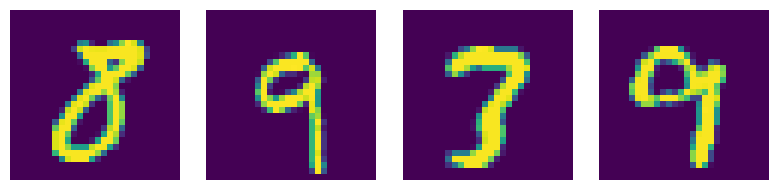

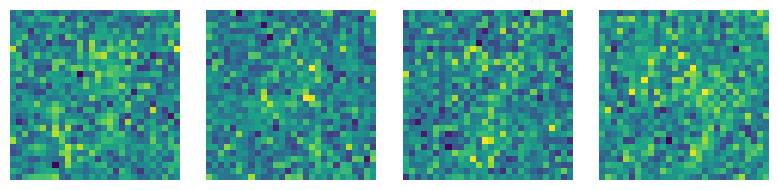

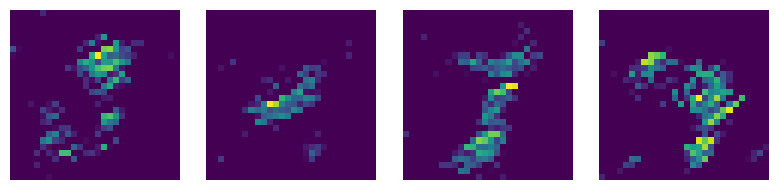

Avg loss = 3.127e-02, lr = 0.005:  10%|█         | 100/1000 [02:10<19:18,  1.29s/it]

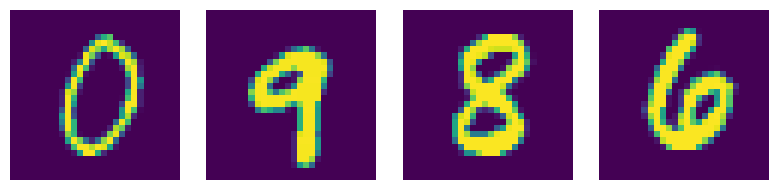

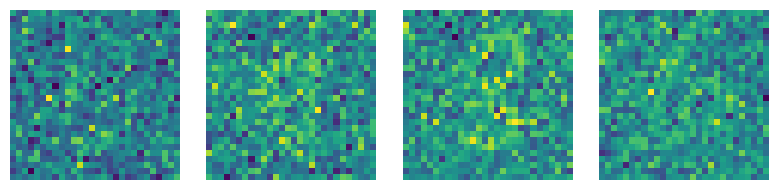

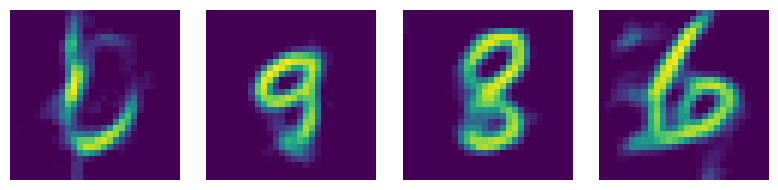

Avg loss = 2.877e-02, lr = 0.005:  20%|██        | 200/1000 [04:20<17:30,  1.31s/it]

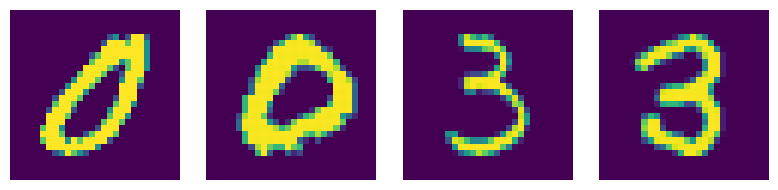

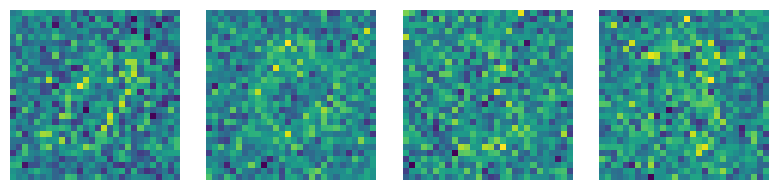

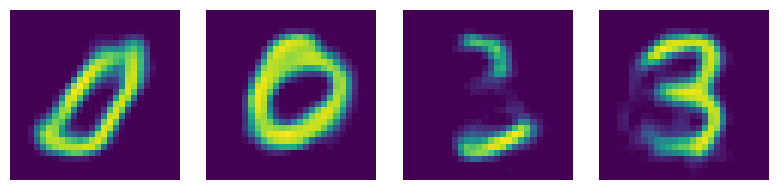

Avg loss = 2.858e-02, lr = 0.005:  30%|███       | 300/1000 [06:30<15:12,  1.30s/it]

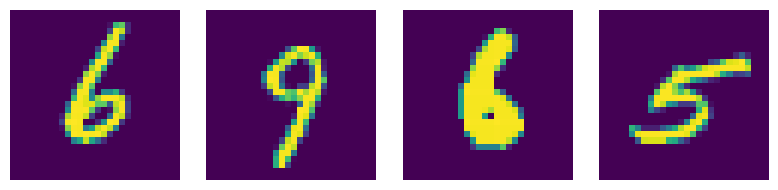

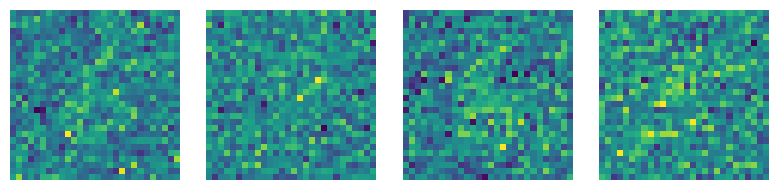

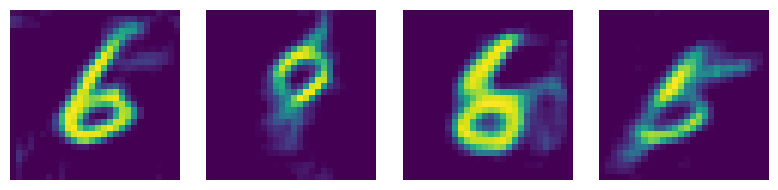

Avg loss = 2.780e-02, lr = 0.005:  40%|████      | 400/1000 [08:41<12:58,  1.30s/it]

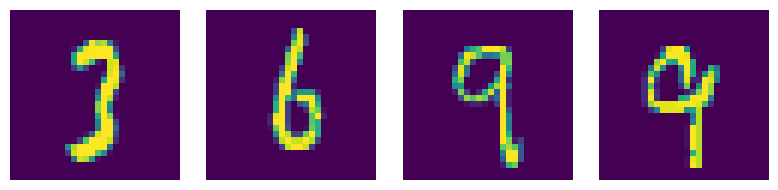

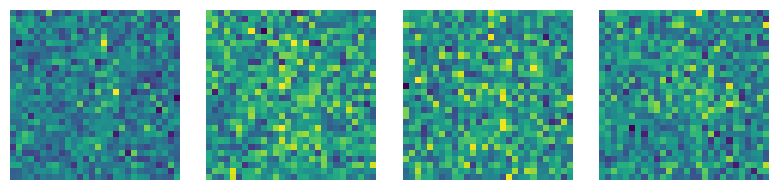

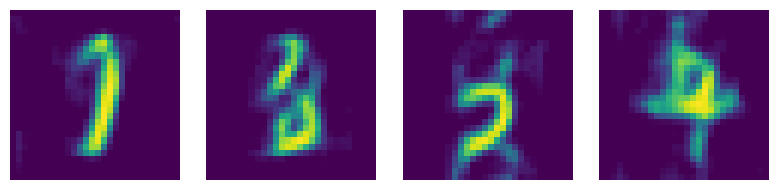

Avg loss = 2.832e-02, lr = 0.005:  47%|████▋     | 470/1000 [11:08<11:28,  1.30s/it]

In [ ]:
train(RN_model, loader, optimizer, loss_fn, epochs=1000)

tensor(2.7047e-06)


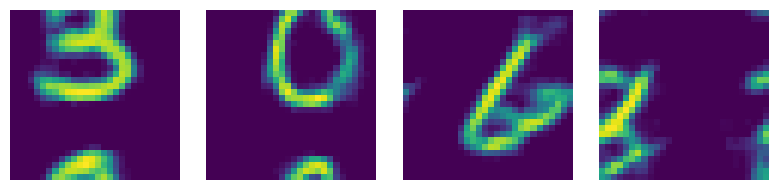

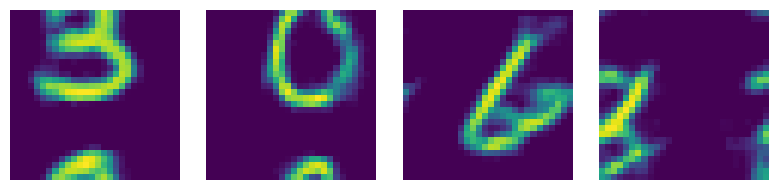

In [ ]:
N = 50
trans = torch.randint(low=0,high=28,size=(N,2))
idx = torch.randint(low = 0, high= 100,size=(N,))
input = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = input + sigma*torch.randn_like(input)
output = predict(RN_model,input)
trans_output = torch.stack([torch.roll(output[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
trans_input =torch.stack([torch.roll(input[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
output_trans = predict(RN_model,trans_input)

diff = torch.mean(torch.linalg.norm((trans_output-output_trans).reshape(50,28*28),dim=1))
print(diff)
show_images(trans_output[:4])
show_images(output_trans[:4])

tensor(6.2407e-07)


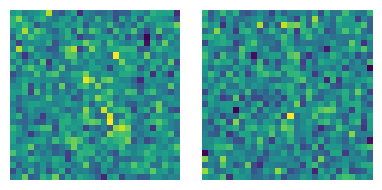

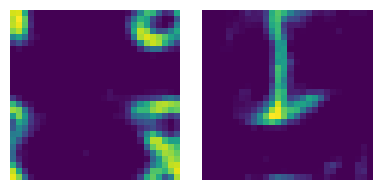

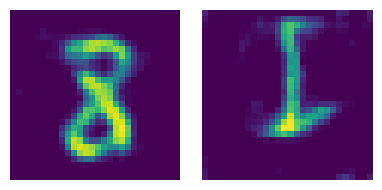

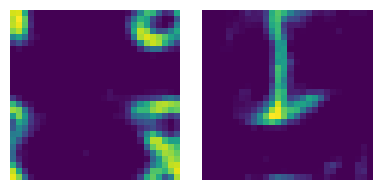

In [ ]:
N = 2
trans = torch.randint(low=0,high=28,size=(N,2))
idx = torch.randint(low = 0, high= 100,size=(N,))
input = torch.stack([dataset[i][0] for i in idx])
# input = torch.randn(100,1,28,28)

input = input + sigma*torch.randn_like(input)
output = predict(RN_model,input)
trans_output = torch.stack([torch.roll(output[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
trans_input =torch.stack([torch.roll(input[i],shifts=(trans[i][0],trans[i][1]),dims=(1,2)) for i in range(N)])
output_trans = predict(RN_model,trans_input)

diff = torch.mean(torch.linalg.norm((trans_output-output_trans).reshape(N,28*28),dim=1))
print(diff)

show_images(input)
show_images(trans_output[:4])

show_images(output)
show_images(output_trans[:4])

**Comment:** Our Resnet is equivariance.

In [79]:
torch.save(RN_model.state_dict(), 'ResNet_conv2d.pt')

In [ ]:
RN_model.load_state_dict(torch.load('ResNet_conv2d.pt'))

In [ ]:
# out = X.to(device)
# model.eval()
# with torch.no_grad():
#     for submodel in model.layers:
#         out = submodel(out)
#         show_images(out[:4, 0:1])

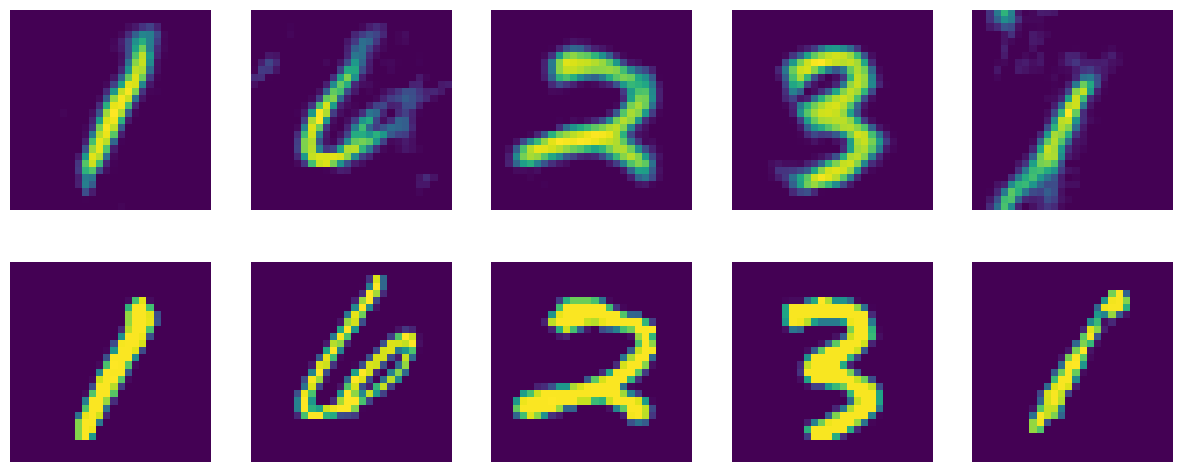

In [94]:
train_pred = predict(RN_model,Y+sigma*torch.randn_like(Y))
fig,axs = plt.subplots(2,5,figsize=(15,6))
axs = axs.flat
for i in range(5):
    axs[i].imshow(train_pred[i].squeeze())
    axs[i].axis('off')
for i in range(5,10):
    axs[i].imshow(Y[i-5].squeeze())   
    axs[i].axis('off')

plt.show()

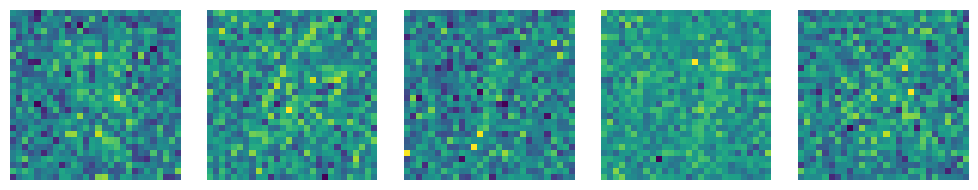

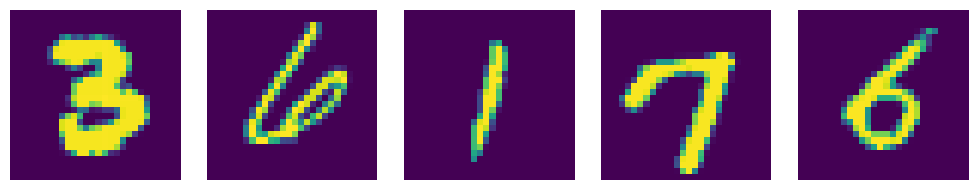

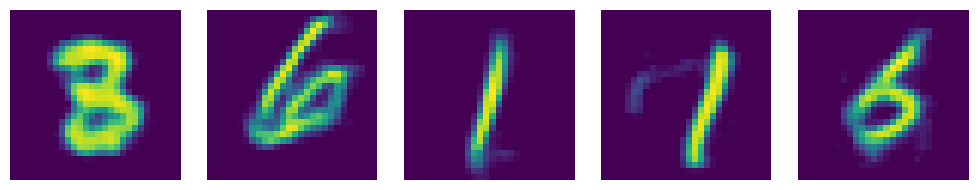

In [102]:
idx = torch.randint(low=0, high=100,size=(5,))
y_new_noiseless = Y[idx]
y_new = y_new_noiseless + sigma * torch.randn_like(y_new_noiseless)
im_generated = predict(RN_model,y_new)
# show_images(torch.cat([y_new, im_generated, y_new_noiseless], dim = 0))
show_images(y_new)
show_images(y_new_noiseless)
show_images(im_generated)


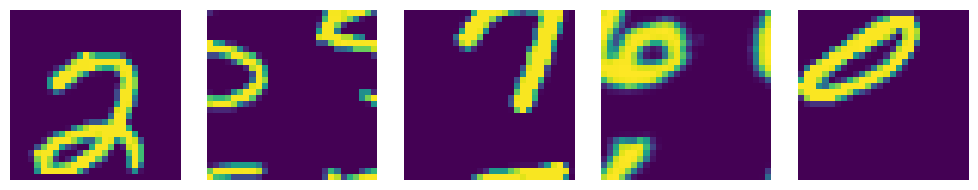

In [134]:

weights = [weights_calculation(x_input=y,dataset=translated_dataset) for y in trans_input[:5] ]

weights = torch.stack(weights)
weights = weights[:,:,None,None]
# _, top_indices = torch.topk(weights, k=750)
image_predicted_analytic = torch.mean((translated_dataset.unsqueeze(0)*weights),dim=1,keepdim=True)
show_images(image_predicted_analytic)